In [3]:
# Imports for numerical calculations
import math
import numpy as np
import gmpy2
from fpylll import IntegerMatrix, LLL

# Utility
import sys
import time
import matplotlib.pyplot as plt

In [19]:
### Define helper functions

def recover_sparse_cyclotomic(p: int, t: int, Mscale: int, Nscale: int, last_root: bool, noise: gmpy2.mpfr, prec=53) -> tuple[np.typing.NDArray[np.int_], list[list[int]]]:
    """For a randomly generated cyclotomic integer `z` summed from `l` `p`th roots of unity,
    generates LLL (short, nearly orthogonal) basis vectors to approximate `z` with integer relations. \n

    Each basis vector `vec` consists of:
    - `vec[0:2]` corresponding to the Re and Im parts of the objective value.
    - `vec[2:p+1+last_root]` corresponding to the coefficients for each root of unity.
    - `vec[-1]` corresponding to the target value.

    ### Parameters:
    - `p`: order of root of unity.
    - `t`: number of nonzero integer terms in cyclotomic integer decomposition.
    - `Mscale`: lattice scaling factor for objective complex values.
    - `Nscale`: lattice scaling factor for number of vectors summed.
    - `last_root`: whether to include `p-1`th root of unity in linear combinations. Default is `True`.
    - `noise`: standard deviation of Gaussian noise to include in input cyclotomic integer. Default is `0.0`.
    - `prec`: number of precision bits to define float mantissa. Default `53` uses IEEE-754 `numpy.float64` for speed.

    ### Returns:
    - `exps`: list of number of roots of unity used in summing z, where `exps[i]` corresponds to the `i`th root.
    - `lll_mat`: list of candidate basis vectors as output of LLL algorithm.
    """

    # TODO: find whether there is a better initial ordering of basis vectors

    # Generate roots of unity to sum
    rng = np.random.default_rng()
    negatives = rng.choice(p, size=rng.integers(t), replace=False)
    exps = np.multiply(
        rng.multinomial(t, [1.0 / p] * p), 
        [-2 * (i in negatives) + 1 for i in range(p)]
    )

    # Default precision: use numpy.float64 for speed
    if prec == 53:
        # Generate cyclotomic integer
        angles = 2 * np.pi * np.arange(p) / p
        roots_re = np.cos(angles)
        roots_im = np.sin(angles)
        z_re = np.dot(exps, roots_re)
        z_im = np.dot(exps, roots_im)

        # Add complex random Gaussian noise with stdev noise
        if noise:
            z_re += rng.normal(scale=noise/math.sqrt(2))
            z_im += rng.normal(scale=noise/math.sqrt(2))
    
    # Arbitrary precision: use gmpy2 wrapper of GMP and MPFR
    else:
        if prec < 1:
            raise ValueError("Precision must be a positive integer.")

        # Set up arbitrary precision environment
        ctx = gmpy2.get_context()
        ctx.precision = prec

        roots_re = [gmpy2.cos((2 * gmpy2.const_pi() * i) / p) for i in range(p)]
        roots_im = [gmpy2.sin((2 * gmpy2.const_pi() * i) / p) for i in range(p)]
        z_re = sum(root_re * exp for root_re, exp in zip(roots_re, exps))
        z_im = sum(root_im * exp for root_im, exp in zip(roots_im, exps))

        if noise:
            rs = gmpy2.random_state(int(rng.integers(sys.maxsize)))
            z_re += gmpy2.mpfr_nrandom(rs) * noise/gmpy2.rootn(2, 2)
            z_im += gmpy2.mpfr_nrandom(rs) * noise/gmpy2.rootn(2, 2)

    # Construct the lattice basis matrix
    B = IntegerMatrix(p + last_root, p + 2 + last_root)

    for i in range(p - 1 + last_root):
        B[i, 0] = int(round(roots_re[i] * Mscale)) # roots of unity real parts
        B[i, 1] = int(round(roots_im[i] * Mscale)) # roots of unity imaginary parts
        B[i, 2 + i] = Nscale # identity matrix
    
    # Set target row to real + imaginary parts and target superposition value
    B[-1, 0] = -1 * int(round(z_re * Mscale))
    B[-1, 1] = -1 * int(round(z_im * Mscale))
    B[-1, -1] = 1

    LLL.reduction(B)
    return exps, B


def run_trials(orders: list[int], t: int, Mscale: int, Nscale: int, last_root: bool, num_trials: int, noise: gmpy2.mpfr, prec=53) -> list[int]:
    """Tests success rate of using LLL algorithm to solve
    the cyclotomic integer decomposition integer relation problem.

    ### Parameters:
    - `orders`: list of orders of root of unity to test.
    - `t`: number of nonzero integer terms in cyclotomic integer decomposition.
    - `Mscale`: lattice scaling factor for objective complex values.
    - `Nscale`: lattice scaling factor for integer mapping. If set to 0:
    \t - in the noiseless case (`noise == 0.0`), `Nscale` defaults to `1`.
    \t - in the noisy case, computes optimal `Nscale` for each prime in `primes` for best success rate.
    - `last_root`: whether to include `p-1`th root of unity in linear combinations.
    - `num_trials`: number of trials to run for each `p` in `orders`.
    - `noise`: standard deviation of Gaussian noise to include in input cyclotomic integer.
    - `prec`: number of precision bits to define float mantissa. Default `53` uses IEEE-754 `numpy.float64`.

    ### Returns:
    - `results`: list of number of successes corresponding to `orders`.
    """

    # Generate placeholder to record correct trials and time taken for each prime
    results = [0] * len(orders)
    
    for i in range(len(orders)):
        # autocomputes Nscale if given noise
        if Nscale == 0 and noise != 0:
            Nval = (Mscale * orders[i] * noise) // (4.5 * (t ** (2/3)))
        else:
            Nval = max(Nscale, 1)

        for _ in range(num_trials):
            exps, lll_mat = recover_sparse_cyclotomic(orders[i], t, Mscale=Mscale, Nscale=Nval, last_root=last_root, noise=noise, prec=prec)

            # Match successful candidate vectors
            for row in list(lll_mat):
                row = list(row)
                if abs(row[-1]) == 1:
                    # Construct desired histogram of roots of unity
                    expected_arr = Nval * exps

                    # Check if candidate vector and desired histogram differ by all 1's vector
                    if not last_root:
                        row[:-1].extend([0, row[-1]])
                    diff_vec = np.multiply(row[-1], row[2:-1]) - expected_arr
                    results[i] += (diff_vec == diff_vec).all()
                    break
    return results


def run_trials_timed(orders: list[int], t: int, Mscale: int, Nscale: int, last_root: bool, num_trials: int, noise: gmpy2.mpfr, prec=53) -> tuple[list[int], list[float]]:
    """Tests success rate and times of using LLL algorithm to solve
    the cyclotomic integer decomposition integer relation problem.
    See `run_trials` for input details.

    ### Returns:
    - `results`: list of number of successes corresponding to `orders`.
    - `times`: list of times (in seconds) needed to run all trials for each prime in `orders`.
    """

    # Generate placeholder to record correct trials and time taken for each prime
    results = [0] * len(orders)
    times = [0.0] * len(orders)
    
    for i in range(len(orders)):
        start_time = time.time()
        
        # autocomputes Nscale if given noise
        if Nscale == 0 and noise != 0:
            Nval = (Mscale * orders[i] * noise) // (4.5 * (t ** (2/3)))
        else:
            Nval = max(Nscale, 1)

        for _ in range(num_trials):
            exps, lll_mat = recover_sparse_cyclotomic(orders[i], t, Mscale=Mscale, Nscale=Nval, last_root=last_root, noise=noise, prec=prec)

            # Match successful candidate vectors
            for row in list(lll_mat):
                row = list(row)
                if abs(row[-1]) == 1:
                    # Construct desired histogram of roots of unity
                    expected_arr = Nval * exps

                    # Check if candidate vector and desired histogram differ by all 1's vector
                    if not last_root:
                        row[:-1].extend([0, row[-1]])
                    diff_vec = np.multiply(row[-1], row[2:-1]) - expected_arr
                    results[i] += int((diff_vec == diff_vec[0]).all())
                    break
        
        # Record times for prime
        times[i] = time.time() - start_time
    return results, times


In [18]:
### Check LLL matrix output and selected candidates for a single trial
Nval = int((10 ** 20 * 5 * 0.001) // (4.5 * (5 ** (2/3))))
exps, lll_mat = recover_sparse_cyclotomic(5, 5, Mscale=10**20, Nscale=Nval, last_root=True, noise=gmpy2.exp10(-3), prec=128)
print(exps)
print(lll_mat)

for row in lll_mat:
    row = list(row)
    if abs(row[-1]) == 1:
        print(np.divide(row[2:-1], Nval))
        break

[2 1 1 1 0]
[   39598303479145269   -4650335728613344   37999465481704376                    0                   0                   0  -37999465481704376   1 ]
[                   0                   0   37999465481704376    37999465481704376   37999465481704376   37999465481704376   37999465481704376   0 ]
[  940674520846460710  139510071858400320 -417994120298748136  -569991982225565640  227996792890226256  227996792890226256  569991982225565640 -30 ]
[  504230042231173737 1144215852828030814  -75998930963408752   341995189335339384  341995189335339384 -949986637042609400  265996258371930632  23 ]
[ -612477049670894784  167412086230080384  493993051262156888 -1519978619268175040  569991982225565640  569991982225565640 -151997861926817504 -36 ]
[  272345743027504010  866274509492201653 -417994120298748136   341995189335339384 -949986637042609400 1139983964451131280 -189997327408521880 -20 ]
[ 1.  0.  0.  0. -1.]


In [21]:
### Run trials

# As of last commit: this space iterates through potential error and superposition values. 
# A prime stops being tested when its accuracy values fall too low.

# orders = [11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

trials = 1000
# orders = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
# Mlogs = np.arange(3, 16)
# Nlogs = np.arange(0.5, 13, 0.5)
orders = np.arange(5, 10)
M = 10 ** 15

results, times = run_trials_timed(orders=orders, t=3, Mscale=M, Nscale=20, last_root=True, num_trials=trials, noise=0, prec=256)
# print(f"log t = {round(tlog, 1)}: {results}")

# print(f"Results: {results}")
print(results)
print(np.round(times, 3))

[1000, 25, 1000, 86, 306]
[0.218 0.258 0.262 0.385 0.321]


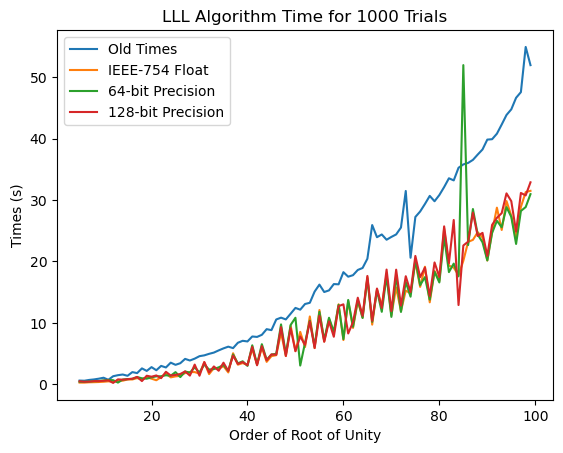

In [5]:
### Plot algorithm times for old code and new code

orders = np.arange(5, 100)
y_old = [
    0.618, 0.592, 0.723, 0.804, 0.926, 1.082,
    0.743, 1.326, 1.495, 1.605, 1.397, 1.997,
    1.836, 2.602, 2.190, 2.808, 2.301, 3.006,
    2.751, 3.533, 3.182, 3.444, 4.147, 3.884,
    4.187, 4.590, 4.722, 4.969, 5.174, 5.530,
    5.858, 6.137, 5.899, 6.770, 7.089, 6.985,
    7.793, 7.721, 8.064, 8.984, 8.825, 10.560,
    10.855, 10.569, 11.496, 12.439, 12.154, 13.076,
    13.272, 15.096, 16.231, 15.027, 15.292, 16.318,
    16.279, 18.254, 17.521, 17.766, 18.615, 18.937,
    20.446, 25.922, 23.943, 24.390, 23.534, 23.990,
    24.396, 25.519, 31.465, 20.600, 27.235, 28.129,
    29.351, 30.667, 29.793, 30.806, 32.101, 33.531,
    33.187, 35.240, 35.786, 36.028, 36.525, 37.391,
    38.218, 39.824, 39.887, 40.784, 42.277, 43.828,
    44.749, 46.626, 47.544, 54.902, 51.937
]
y_new = [
    0.292, 0.288, 0.341, 0.356, 0.386, 0.425, 0.493, 0.466, 0.61, 0.6,
    0.8, 0.8, 1.018, 0.812, 1.176, 0.926, 0.67, 1.19, 1.773, 1.142,
    1.302, 1.389, 1.848, 2, 2, 1.753, 3.606, 1.671, 2.66, 2.501,
    2.974, 1.944, 5.067, 3.202, 3.463, 3.168, 5.766, 3.261, 5.969, 3.664,
    4.6, 4.749, 8.436, 4.6, 9.567, 5.442, 8.543, 6.073, 11.047, 5.903,
    12.093, 6.97, 10.684, 8.334, 13.021, 7.217, 13.572, 9.177, 13.584, 10.833,
    17.446, 9.721, 15.475, 12.789, 17.882, 11.25, 15.782, 11.923, 15.258, 14.814,
    19.961, 15.861, 19.142, 13.351, 18.449, 16.799, 25.346, 19.332, 18.999, 17.762,
    20.098, 23.181, 23.51, 24.763, 23.886, 20.143, 24.822, 28.751, 25.118, 29.825,
    27.444, 23.77, 28.871, 31.283, 31.488
]
y_64 = [
    0.423, 0.416, 0.466, 0.531, 0.538, 0.653, 0.718, 0.682, 0.293, 0.788,
    0.859, 0.899, 1.194, 0.986, 0.928, 1.143, 1.309, 1.32, 1.485, 1.407,
    1.992, 1.184, 2.101, 1.91, 2.771, 1.929, 3.23, 2.404, 2.497, 2.769,
    3.134, 2.227, 4.855, 3.422, 3.757, 3.012, 6.359, 3.241, 6.538, 3.996,
    4.863, 4.969, 9.756, 4.895, 9.673, 10.837, 3.065, 6.746, 10.361, 6.181,
    11.791, 7.204, 10.84, 8.552, 12.941, 7.365, 13.733, 9.369, 13.73, 10.805,
    17.191, 10.178, 15.277, 11.8, 17.609, 10.981, 17.677, 11.786, 16.67, 14.266,
    20.223, 16.147, 17.448, 13.783, 18.331, 16.583, 23.99, 18.264, 19.651, 17.568,
    51.944, 22.667, 28.527, 24.375, 23.111, 20.174, 24.64, 26.612, 25.564, 28.84,
    27.245, 22.849, 28.209, 28.848, 30.952
]
y_128 = [
    0.502, 0.429, 0.448, 0.532, 0.527, 0.585, 0.655, 0.237, 0.817, 0.759,
    0.841, 0.919, 1.213, 0.539, 1.404, 1.247, 1.454, 1.009, 2.047, 1.441,
    1.535, 1.691, 2.106, 1.43, 3.218, 1.409, 3.636, 1.932, 2.917, 2.217,
    3.529, 2.181, 4.679, 3.32, 3.639, 3.113, 6.114, 3.106, 6.226, 3.911,
    4.872, 4.817, 9.314, 4.627, 9.126, 5.39, 7.795, 6.427, 10.235, 5.919,
    11.161, 6.932, 10.249, 7.747, 12.728, 13.025, 8.281, 10.119, 14.103, 11.144,
    17.642, 10.335, 15.596, 12.429, 18.679, 11.904, 18.661, 12.816, 17.597, 15.017,
    20.901, 17.439, 19.01, 14.363, 19.839, 17.485, 25.708, 19.723, 26.747, 12.909,
    22.593, 23.218, 27.949, 24.144, 24.647, 20.893, 25.95, 27.097, 27.857, 31.075,
    29.805, 24.858, 31.139, 30.747, 32.875
]
y_256 = [

]
plt.plot(orders, y_old, label="Old Times")
plt.plot(orders, y_new, label="IEEE-754 Float")
plt.plot(orders, y_64, label="64-bit Precision")
plt.plot(orders, y_128, label="128-bit Precision")
# plt.plot(orders, y_256, label="256-bit Precision")
plt.title("LLL Algorithm Time for 1000 Trials")
plt.xlabel("Order of Root of Unity")
plt.ylabel("Times (s)")
plt.legend()
plt.show()

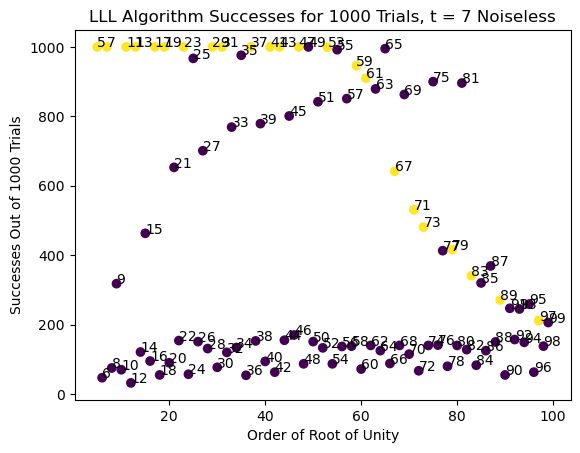

In [ ]:
### Plot successes over p for t = 3, 7

orders = np.arange(5, 100)
results3n = [1000, 47, 1000, 75, 318, 70, 1000, 32, 1000, 121, 463, 95, 1000, 55, 1000, 90, 653, 154, 1000, 57, 967, 151, 701, 131, 1000, 77, 1000, 120, 769, 134, 976, 54, 1000, 153, 779, 94, 1000, 63, 1000, 155, 801, 170, 1000, 87, 1000, 151, 842, 133, 999, 87, 992, 137, 851, 138, 946, 72, 910, 140, 879, 125, 995, 88, 642, 140, 863, 115, 531, 67, 481, 140, 900, 141, 413, 80, 416, 140, 896, 128, 341, 83, 320, 125, 369, 150, 271, 55, 247, 157, 245, 149, 259, 63, 212, 138, 206]
results3n_64 = [1000, 37, 1000, 76, 351, 44, 1000, 31, 1000, 97, 435, 109, 1000, 59, 1000, 104, 611, 94, 1000, 61, 977, 101, 704, 128, 1000, 46, 1000, 95, 770, 100, 982, 51, 1000, 108, 806, 87, 1000, 55, 1000, 108, 796, 108, 1000, 63, 1000, 126, 830, 108, 994, 52, 995, 105, 847, 110, 932, 66, 840, 115, 870, 115, 994, 60, 687, 123, 872, 111, 634, 63, 488, 111, 887, 152, 459, 60, 403, 99, 886, 110, 329, 61, 353, 138, 629, 132, 285, 72, 250, 105, 296, 118, 220, 80, 202, 109, 203]
results3n_128 = [1000, 31, 1000, 88, 312, 40, 1000, 25, 1000, 90, 453, 96, 1000, 44, 1000, 90, 638, 103, 1000, 52, 970, 96, 709, 105, 1000, 59, 1000, 101, 727, 94, 982, 65, 1000, 100, 806, 108, 1000, 61, 1000, 110, 795, 102, 1000, 65, 1000, 103, 820, 127, 1000, 60, 995, 111, 844, 134, 936, 50, 833, 128, 867, 97, 994, 49, 694, 113, 874, 115, 654, 64, 498, 105, 890, 123, 421, 56, 414, 127, 896, 103, 358, 61, 308, 124, 608, 118, 273, 60, 254, 108, 292, 131, 221, 66, 188, 121, 195]
results3n_256 = [] # lost to a disconnection :(
results3o = [
    1000.0, 18.0, 1000.0, 37.0, 196.0, 60.0, 1000.0, 51.0, 1000.0, 109.0, 479.0, 67.0,
    1000.0, 94.0, 1000.0, 100.0, 609.0, 144.0, 1000.0, 132.0, 980.0, 159.0, 678.0, 139.0,
    1000.0, 172.0, 1000.0, 114.0, 762.0, 149.0, 992.0, 126.0, 1000.0, 143.0, 780.0, 109.0,
    1000.0, 133.0, 1000.0, 175.0, 822.0, 158.0, 1000.0, 172.0, 1000.0, 150.0, 819.0, 135.0,
    999.0, 188.0, 994.0, 154.0, 849.0, 130.0, 963.0, 168.0, 949.0, 135.0, 854.0, 147.0,
    998.0, 205.0, 776.0, 141.0, 882.0, 139.0, 681.0, 179.0, 678.0, 129.0, 881.0, 147.0,
    567.0, 173.0, 561.0, 121.0, 894.0, 160.0, 458.0, 163.0, 463.0, 135.0, 384.0, 135.0,
    368.0, 153.0, 391.0, 159.0, 284.0, 148.0, 338.0, 198.0, 307.0, 122.0, 236.0
]
results7o = [
    1000.0, 116.0, 1000.0, 124.0, 300.0, 10.0, 1000.0, 1.0, 1000.0, 0.0, 0.0, 0.0,
    1000.0, 0.0, 1000.0, 2.0, 4.0, 5.0, 1000.0, 0.0, 291.0, 2.0, 34.0, 2.0,
    1000.0, 0.0, 1000.0, 3.0, 90.0, 4.0, 534.0, 1.0, 1000.0, 0.0, 139.0, 2.0,
    1000.0, 1.0, 1000.0, 8.0, 143.0, 3.0, 990.0, 1.0, 931.0, 4.0, 226.0, 5.0,
    965.0, 1.0, 806.0, 0.0, 292.0, 2.0, 667.0, 1.0, 613.0, 3.0, 329.0, 5.0,
    844.0, 1.0, 320.0, 4.0, 368.0, 5.0, 213.0, 1.0, 178.0, 3.0, 358.0, 11.0,
    135.0, 0.0, 118.0, 5.0, 418.0, 5.0, 81.0, 1.0, 67.0, 1.0, 58.0, 5.0,
    53.0, 3.0, 34.0, 6.0, 29.0, 8.0, 48.0, 3.0, 22.0, 3.0, 8.0
]
plt.scatter(orders, results3n, c=[is_prime(p) for p in orders])
plt.title("LLL Algorithm Successes for 1000 Trials, t = 3 Noiseless")
plt.xlabel("Order of Root of Unity")
plt.ylabel("Successes Out of 1000 Trials")

for i in range(len(orders)):
    plt.annotate(orders[i], (orders[i], results3n[i]))

plt.show()

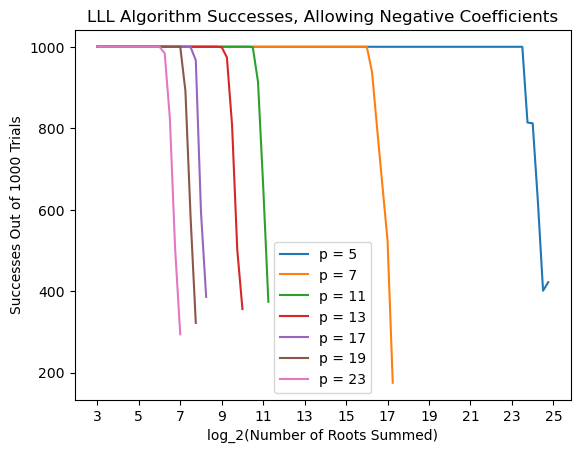

In [3]:
### Plot algorithm successes for p = 5, 7, 11, 13, 17, 19, 23
# check if precision was 53? I forgot
t5 = np.arange(3.0, 25.0, 0.25)
t7 = np.arange(3.0, 17.5, 0.25)
t11 = np.arange(3.0, 11.5, 0.25)
t13 = np.arange(3.0, 10.25, 0.25)
t17 = np.arange(3.0, 8.5, 0.25)
t19 = np.arange(3.0, 8, 0.25)
t23 = np.arange(3.0, 7.25, 0.25)
successes5 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 814, 812, 621, 401, 422]
successes7 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 938, 798, 660, 524, 175]
successes11 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 914, 659, 374]
successes13 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 974, 807, 502, 356]
successes17 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 967, 594, 386]
successes19 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 891, 580, 322]
successes23 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 984, 824, 507, 294]
plt.plot(t5, successes5, label='p = 5')
plt.plot(t7, successes7, label='p = 7')
plt.plot(t11, successes11, label='p = 11')
plt.plot(t13, successes13, label='p = 13')
plt.plot(t17, successes17, label='p = 17')
plt.plot(t19, successes19, label='p = 19')
plt.plot(t23, successes23, label='p = 23')
plt.title("LLL Algorithm Successes, Allowing Negative Coefficients")
plt.xlabel("log_2(Number of Roots Summed)")
plt.xticks(np.arange(3, 27, 2))
plt.ylabel("Successes Out of 1000 Trials")
plt.legend()
plt.show()

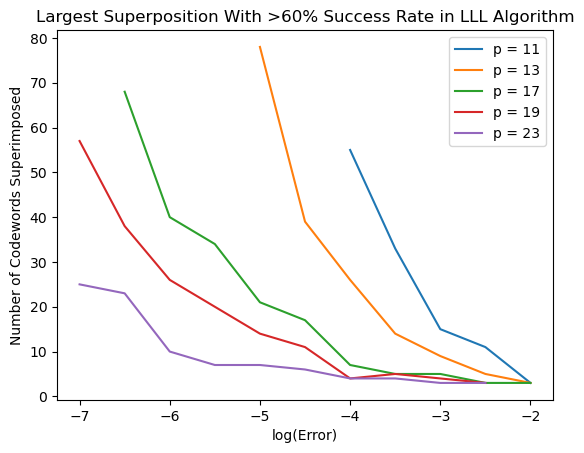

In [ ]:
### Plot max superposition for p = 11, 13, 17, 19, 23 vs error (outdated)

log_error11 = np.arange(-4.0, -1.5, 0.5)
log_error13 = np.arange(-5.0, -1.5, 0.5)
log_error17 = np.arange(-6.5, -1.5, 0.5)
log_error19 = np.arange(-7.0, -2.0, 0.5)
successes11e = [55, 33, 15, 11, 3]
successes13e = [78, 39, 26, 14, 9, 5, 3]
successes17e = [68, 40, 34, 21, 17, 7, 5, 5, 3, 3]
successes19e = [57, 38, 26, 20, 14, 11, 4, 5, 4, 3]
successes23e = [25, 23, 10, 7, 7, 6, 4, 4, 3, 3]
plt.plot(log_error11, successes11e, label='p = 11')
plt.plot(log_error13, successes13e, label='p = 13')
plt.plot(log_error17, successes17e, label='p = 17')
plt.plot(log_error19, successes19e, label='p = 19')
plt.plot(log_error19, successes23e, label='p = 23')
plt.title("Largest Superposition With >60% Success Rate in LLL Algorithm")
plt.xlabel("log(Error)")
plt.xticks([-7, -6, -5, -4, -3, -2])
plt.ylabel("Number of Codewords Superimposed")
plt.legend()
plt.show()


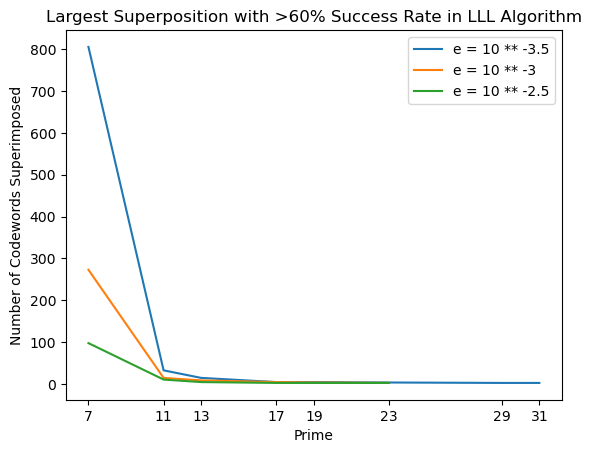

In [ ]:
### Plot max superposition for e = 10 ** -3.5 (outdated)
primes_25 = [7, 11, 13, 17, 19, 23]
primes_35 = [7, 11, 13, 17, 19, 23, 29, 31]
superpositions25 = [98, 11, 5, 3, 3, 3]
superpositions30 = [273, 15, 9, 5, 4, 3]
superpositions35 = [805, 33, 15, 5, 5, 4, 3, 3]
plt.plot(primes_35, superpositions35, label="e = 10 ** -3.5")
plt.plot(primes_25, superpositions30, label="e = 10 ** -3")
plt.plot(primes_25, superpositions25, label="e = 10 ** -2.5")
plt.title("Largest Superposition with >60% Success Rate in LLL Algorithm")
plt.xlabel("Prime")
plt.xticks(primes_35)
plt.ylabel("Number of Codewords Superimposed")
plt.legend()
plt.show()

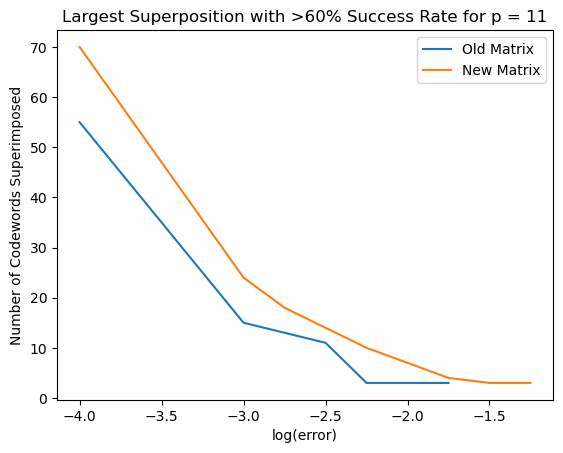

In [57]:
### Plot noise max superpositions in old and new formulations
old_elogs7 = [-3, -2.5, -2.25, -2, -1.75, -1.5, -1.25]
old_elogs11 = [-4, -3, -2.5, -2.25, -2, -1.75]
new_elogs7 = np.arange(-3.0, -0.75, 0.25)
new_elogs11 = [-4, -3, -2.75, -2.5, -2.25, -2, -1.75, -1.5, -1.25]
maxes_old7 = [273, 98, 35, 28, 14, 8, 7]
maxes_old11 = [55, 15, 11, 3, 3, 3]
maxes_new7 = [265, 154, 96, 58, 37, 25, 12, 8, 4]
maxes_new11 = [70, 24, 18, 14, 10, 7, 4, 3, 3]
plt.plot(old_elogs11, maxes_old11, label="Old Matrix")
plt.plot(new_elogs11, maxes_new11, label="New Matrix")
plt.title("Largest Superposition with >60% Success Rate for p = 11")
plt.xlabel("log(error)")
plt.ylabel("Number of Codewords Superimposed")
plt.legend()
plt.show()